### CREATE DAILY INPUT FOR THE ML MODEL

Input:
- the measured runoff at the gauging station,
- the catchment area of the gauging station,
- the ERA5 datasets for Potential Evapotranspiration, Temperature and Precipitation.

Output:
    - a .csv file is saved in conda/daily_input folder.

In [113]:
import sys, importlib
importlib.reload(sys.modules['sf_runoff'])

<module 'sf_runoff' from 'C:\\Users\\mmazzolini\\OneDrive - Scientific Network South Tyrol\\Documents\\conda\\Runoff_prediction\\sf_runoff.py'>

In [1]:
from create_daily_csv import interpolate_df,readnetcdf_in_shp,xarray2df,check_data_gap,readnetcdf_in_shp_db,get_discharge_from_DB
import pandas as pd
import numpy as np
import os
import xarray as xr

In [199]:
STAT_CODE = 'ADO_DSC_ITC1_0027'

In [200]:
runoff=get_discharge_from_DB(STAT_CODE)

In [201]:
runoff

,discharge_m3_s
date,
2003-02-18,0.99
2003-02-19,0.96
2003-02-20,1.01
2003-02-21,1.17
2003-02-22,1.27
...,...
2019-12-27,20.70
2019-12-28,19.40
2019-12-29,19.00


shp_catchment_path = r'C:\Users\mmazzolini\OneDrive - Scientific Network South Tyrol\Documents\qgis\final_delineation'
shp_catchment_fileName =shp_catchment_path + r'\DONAU_Korneuburg.shp'

# Runoff
catchment_name = 'KORONEMBURG_DONAU.txt'
fileName = r'C:\Users\mmazzolini\OneDrive - Scientific Network South Tyrol\data_discharge\\' + catchment_name
#runoff = pd.read_csv(fileName, index_col=2, parse_dates=True)
runoff = pd.read_csv(fileName, delimiter=',', index_col=1
                     , parse_dates=True)

runoff=runoff.drop(columns=['id_station','quality'])

runoff.index = pd.to_datetime(runoff.Datum, format='%d.%m.%Y')

runoff['discharge_m3_s']=runoff['pretok (m3/s)']

#runoff=runoff.drop(columns='pretok (m3/s)')
runoff=runoff.drop(columns=['Datum','temp. vode (°C)','transport suspendiranega materiala (kg/s)','vsebnost suspendiranega materiala (g/m3)'])

<AxesSubplot:xlabel='date'>

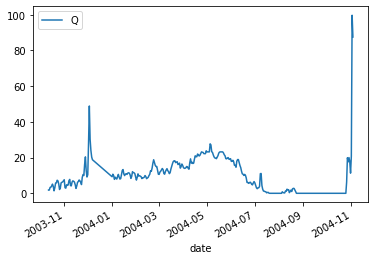

In [16]:

runoff.iloc[365*1:365*2].plot.line()

In [202]:
check_data_gap(runoff)
#runoff = runoff.reindex(pd.date_range(runoff.index.min() - pd.DateOffset(years=1), runoff.index.max()), fill_value=np.nan)
runoff = runoff.rename(columns={'discharge_m3_s': 'Q'})
#runoff.drop(['id_station','quality'],axis=1,inplace=True)

Date start: 2003-02-18, date end: 2019-12-31
No missing dates


n of pixels31


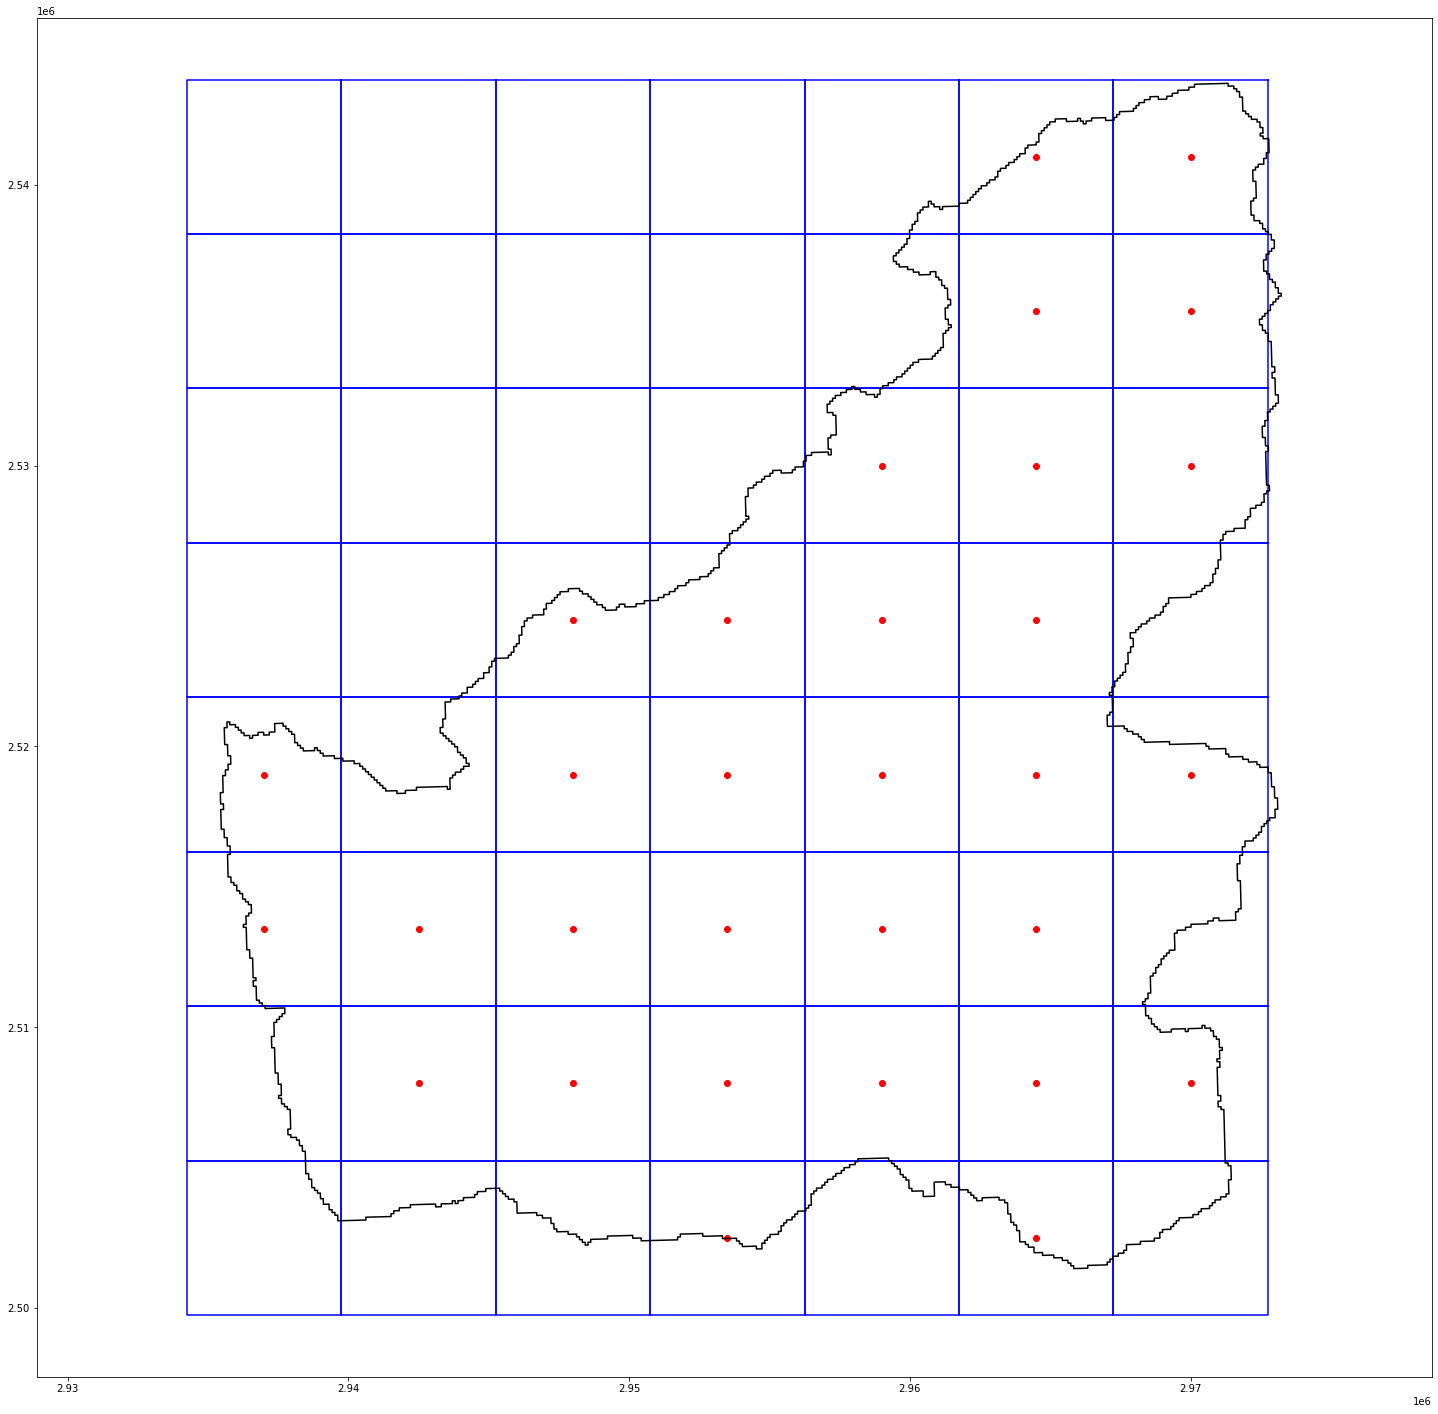

In [203]:
# ERA5 temperature

era5_fileName=  r'C:\Users\mmazzolini\OneDrive - Scientific Network South Tyrol\era5\2m_temperature-19790101_20181231-eusalp-qm_era5.nc'

t2m = readnetcdf_in_shp_db(era5_fileName,STAT_CODE ,plot=True,res=5500)['t2m']
t2m=t2m.assign_coords(time=t2m["time.date"])

index = pd.MultiIndex.from_product([t2m.y.values, t2m.x.values, ['T']],names=['y','x','var'])
reshaped = t2m.values.reshape((t2m.values.shape[0],t2m.values.shape[1]*t2m.values.shape[2]))

T = pd.DataFrame(reshaped, index=t2m.time.values,columns=index)

n of pixels31


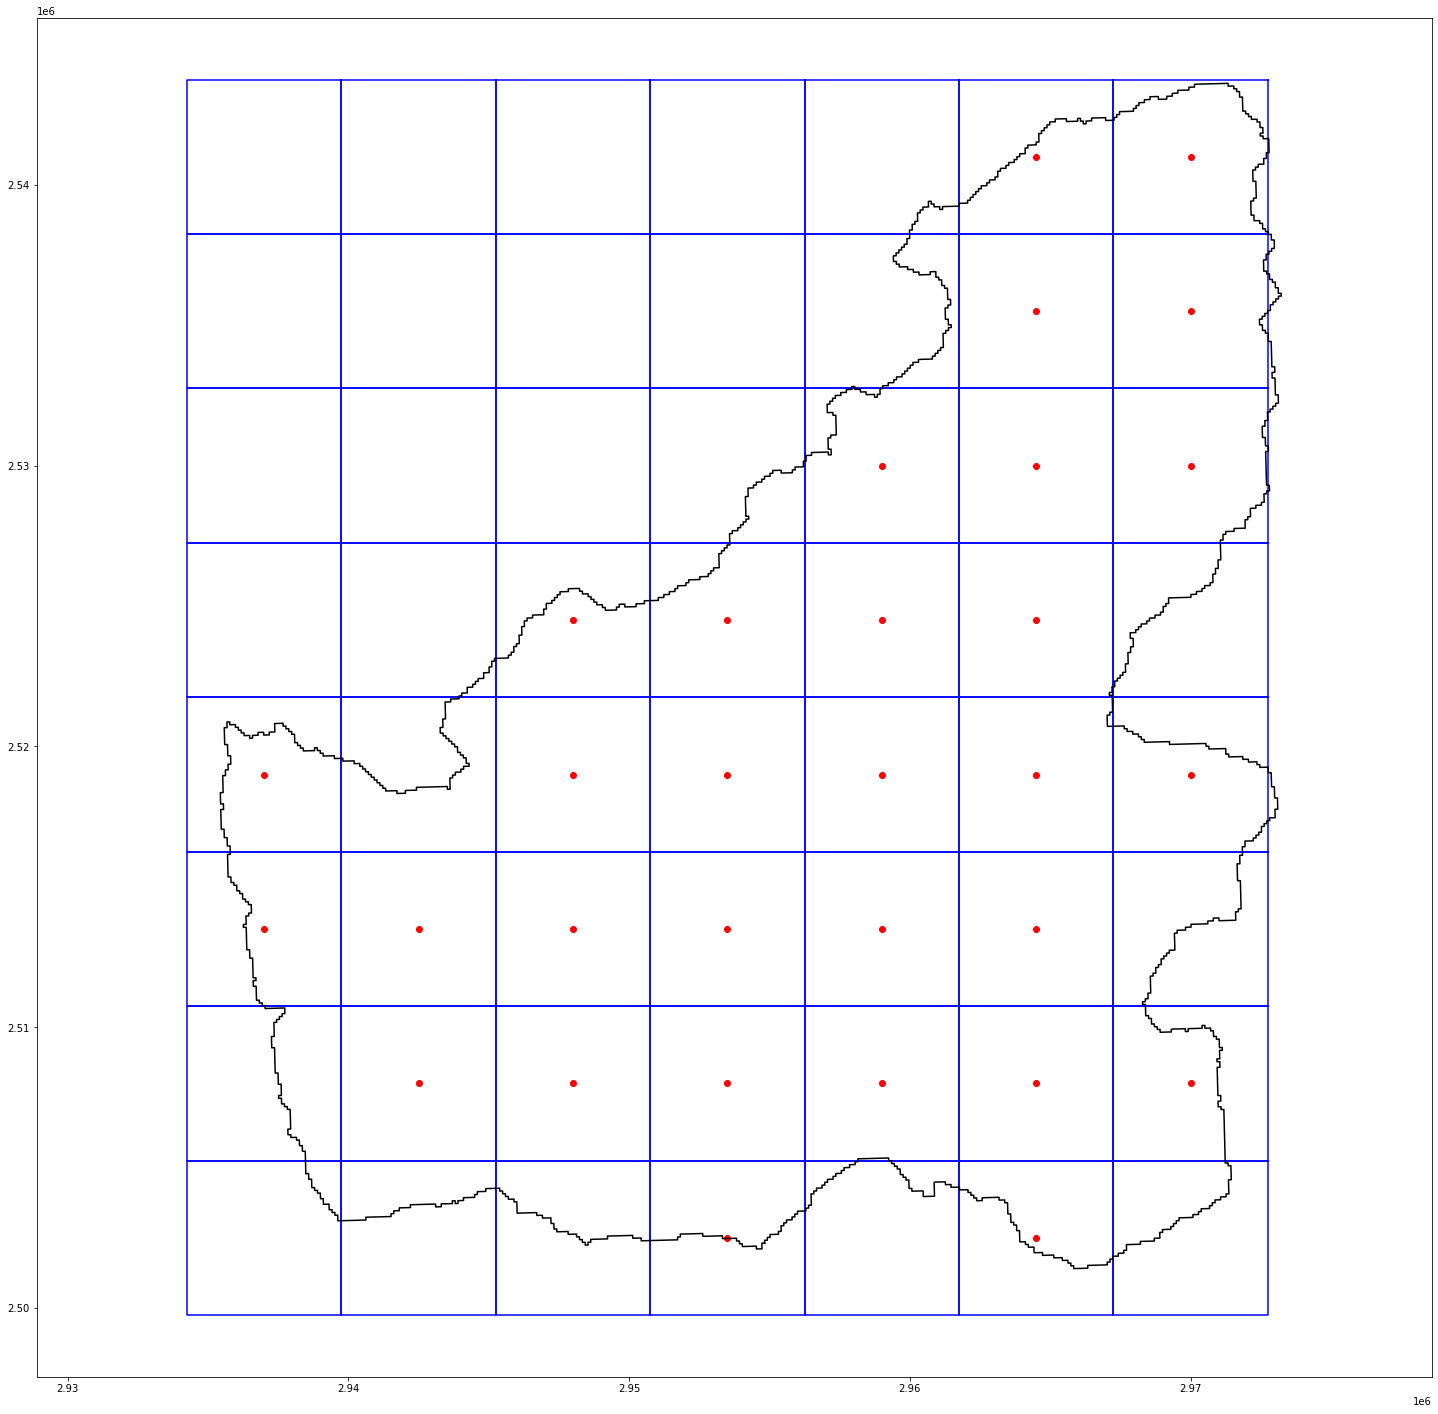

In [204]:
# ERA5 evapotranspiration
era5_fileName = r'C:\Users\mmazzolini\OneDrive - Scientific Network South Tyrol\era5\potential_evapotranspiration-19790101_20181231-eusalp-qm_era5.nc'

pet = readnetcdf_in_shp_db(era5_fileName, STAT_CODE,plot=True)['pet']
pet=pet.assign_coords(time=pet["time.date"])

index = pd.MultiIndex.from_product([pet.y.values, pet.x.values, ['E']],names=['y','x','var'])
reshaped = pet.values.reshape((pet.values.shape[0],pet.values.shape[1]*pet.values.shape[2]))

E = pd.DataFrame(reshaped, index=pet.time.values,columns=index)

n of pixels31


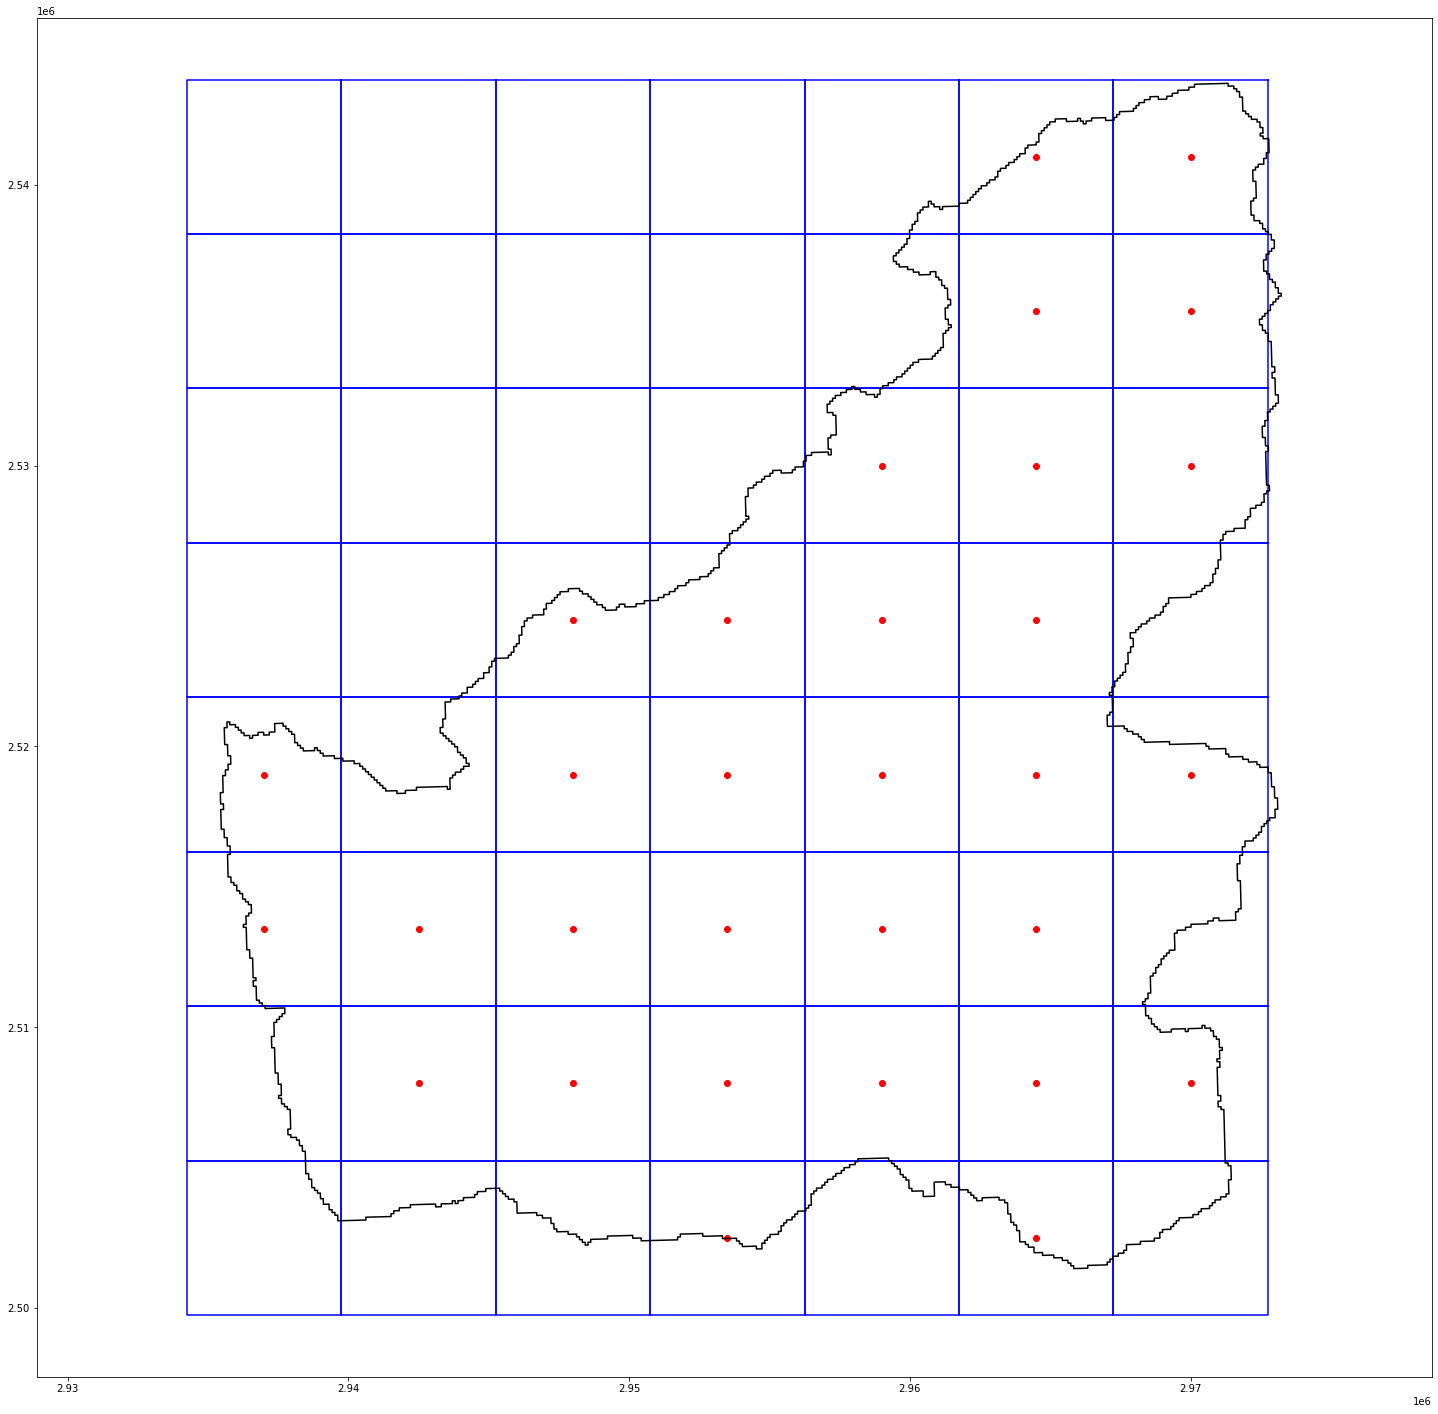

In [205]:
# ERA5 total precipitation
era5_fileName = r'C:\Users\mmazzolini\OneDrive - Scientific Network South Tyrol\era5\total_precipitation-19790101_20181231-eusalp-qm_era5.nc'

tp = readnetcdf_in_shp_db(era5_fileName, STAT_CODE,plot=True)['tp']
tp=tp.assign_coords(time=tp["time.date"])

index = pd.MultiIndex.from_product([tp.y.values,tp.x.values,['P']],names=['y','x','var'])
reshaped = tp.values.reshape((tp.values.shape[0],tp.values.shape[1]*tp.values.shape[2]))

P = pd.DataFrame(reshaped, index=tp.time.values, columns=index)

n of pixels124


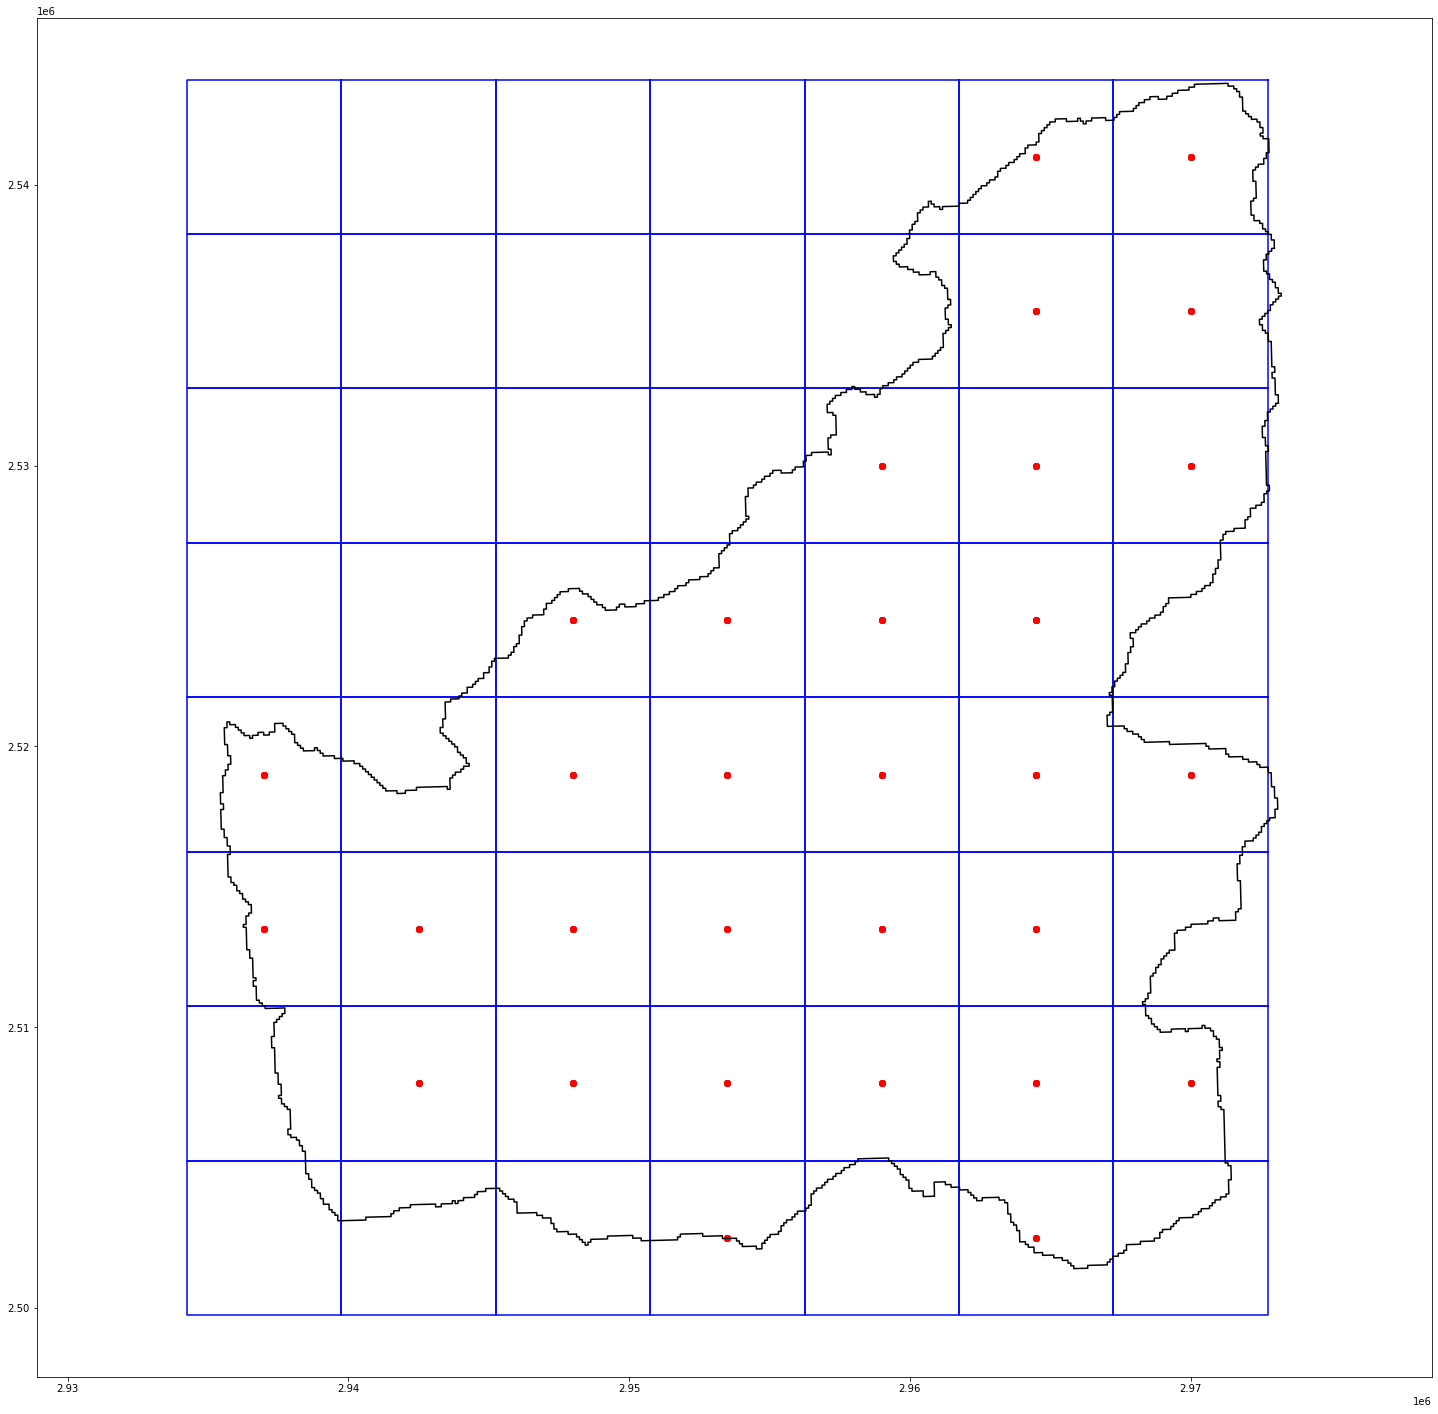

In [206]:
# ERA5 total SNOW VARIABLES
era5_fileName = r'C:\Users\mmazzolini\OneDrive - Scientific Network South Tyrol\era5\SNOWGRID\ado-snowgrid.nc'

s = readnetcdf_in_shp_db(era5_fileName, STAT_CODE,plot=True)['swe_tot']
s=s.assign_coords(time=s["time.date"])

index = pd.MultiIndex.from_product([s.y.values,s.x.values,['S']],names=['y','x','var'])
reshaped = s.values.reshape((s.values.shape[0],s.values.shape[1]*s.values.shape[2]))

S = pd.DataFrame(reshaped, index=s.time.values,columns=index)

S[S < 0] = np.NaN

In [207]:
# Concatenate and save
catchment_name=STAT_CODE + '.csv'
daily_input = pd.concat([T, P, E, S],axis=1)
daily_input.index=pd.to_datetime(daily_input.index)
#daily_input = pd.concat([daily_input,swe.loc[~swe.index.duplicated(keep='first')]], axis=1, join='inner')

In [312]:
daily_input.columns.levels[0].shape

(8,)

In [308]:
path=r'C:\Users\mmazzolini\OneDrive - Scientific Network South Tyrol\Documents\conda\daily_input_cube\\'+catchment_name
#save into a csv file.
# if file does not exist write header 
if not os.path.isfile(path):
   daily_input.to_csv(path)
else: # else print the problem
   print('file already exists')

In [210]:
t_unit=30
t_length = 12
import seaborn as sns
from sf_runoff import shift_series_ ,  create_in_matrix

In [211]:
in_matrix = create_in_matrix(daily_input,t_length,t_unit)
index = pd.MultiIndex.from_product([t2m.y.values, t2m.x.values, ['T', 'P', 'E', 'S'],np.arange(-t_length+1,1)],names=['y','x','var','t_ago'])
in_matrix.columns=index


In [264]:
path=r'C:\Users\mmazzolini\OneDrive - Scientific Network South Tyrol\Documents\conda\input_cube\\'+catchment_name

#save into a csv file.
# if file does not exist write header 
if not os.path.isfile(path):
   in_matrix.to_csv(path)
else: # else print the problem
   print('file already exists')

In [270]:
y_len = in_matrix.columns.levels[0].shape[0]
x_len = in_matrix.columns.levels[1].shape[0]

In [275]:
array=np.array(in_matrix).reshape(dates.shape[0]-1,4,y_len,x_len,t_length)
array=array.swapaxes(4,2)
array=array.swapaxes(4,3)

<AxesSubplot:>

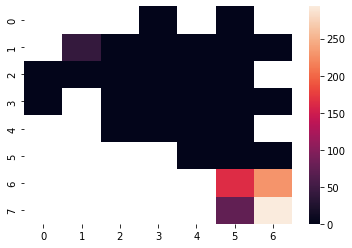

In [276]:
sns.heatmap(data=array[4100,3,4,:,:])

In [278]:
reshaped=array.reshape(dates.shape[0]-1,4*t_length,y_len,x_len)

<AxesSubplot:>

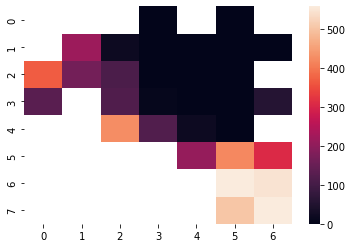

In [279]:
sns.heatmap(data=reshaped[4100,47])

In [288]:
a=pd.read_csv(path,header=[0,1,2,3],index_col=[0])

In [300]:
runoff.index

DatetimeIndex(['2003-02-18', '2003-02-19', '2003-02-20', '2003-02-21',
               '2003-02-22', '2003-02-23', '2003-02-24', '2003-02-25',
               '2003-02-26', '2003-02-27',
               ...
               '2019-12-22', '2019-12-23', '2019-12-24', '2019-12-25',
               '2019-12-26', '2019-12-27', '2019-12-28', '2019-12-29',
               '2019-12-30', '2019-12-31'],
              dtype='datetime64[ns]', name='date', length=6161, freq=None)

In [297]:
a.index.name='date'

In [306]:
a.loc[runoff.index]

y          2502500                                      ...     2541000  \
x          2937000                                      ...     2970000   
var              T                                      ...           S   
t_ago          -11 -10  -9  -8  -7  -6  -5  -4  -3  -2  ...          -9   
date                                                    ...               
2003-02-18     NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...  682.700000   
2003-02-19     NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...  690.300000   
2003-02-20     NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...  698.233333   
2003-02-21     NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...  707.700000   
2003-02-22     NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...  716.933333   
...            ...  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...         ...   
2019-12-27     NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...  734.100000   
2019-12-28     NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...  738.433333   
2019-12-29     NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...  745.466667   
2019-12-30     NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...  754.133333   
2019-12-31     NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...  762.166667   

y                                                                       \
x                                                                        
var                                                                      
t_ago               -8           -7          -6          -5         -4   
date                                                                     
2003-02-18  643.766667   255.000000    6.633333    0.000000  10.333333   
2003-02-19  634.033333   243.166667    4.433333    0.000000  10.766667   
2003-02-20  623.866667   231.466667    2.633333    0.600000  10.633333   
2003-02-21  611.700000   219.866667    1.200000    1.433333  10.400000   
2003-02-22  599.100000   208.133333    0.333333    2.266667  10.566667   
...                ...          ...         ...         ...        ...   
2019-12-27  934.966667  1086.100000  918.700000  428.033333  37.600000   
2019-12-28  942.900000  1088.066667  904.666667  412.000000  31.766667   
2019-12-29  948.033333  1089.600000  890.366667  396.033333  26.500000   
2019-12-30  951.933333  1090.366667  875.933333  380.233333  21.600000   
2019-12-31  956.000000  1090.500000  861.433333  364.433333  17.200000   

y                                                           
x                                                           
var                                                         
t_ago               -3          -2          -1           0  
date                                                        
2003-02-18   67.733333  417.500000  536.333333  637.500000  
2003-02-19   76.233333  424.166667  539.533333  641.200000  
2003-02-20   84.766667  431.300000  542.800000  644.300000  
2003-02-21   93.700000  437.900000  546.166667  647.300000  
2003-02-22  103.900000  442.900000  549.700000  650.066667  
...                ...         ...         ...         ...  
2019-12-27    0.000000    0.000000  133.566667  394.866667  
2019-12-28    0.000000    0.000000  144.533333  399.500000  
2019-12-29    0.000000    0.000000  155.933333  403.700000  
2019-12-30    0.000000    0.000000  167.366667  407.866667  
2019-12-31    0.000000    0.166667  179.100000  411.566667  

[6161 rows x 2688 columns]